# Purpose

Initial evaluation of the impacts of two options in the ACCESS-RNS for initial soil conditions: ERA5-Land or BARRA-R2.
This analysis formed the basis of a presentation by Mathew Lipson at the ACCESS Atmosphere Working Group on 12 Feb 2025.
Presentation is available [here](https://unsw-my.sharepoint.com/:p:/g/personal/z9901702_ad_unsw_edu_au/EVD5yMLs8DxIlBczslBu_oAB6rVGUdjrxqBAM9F2XBLxbQ?e=zsppuQ).
Free-running experiments are compared with the reanalysis product BARRA (12km and 4.4km resolutions)

In [32]:
__version__ = "2025-02-12"
__author__ = "Mathew Lipson"
__email__ = "m.lipson@unsw.edu.au"

import xarray as xr
import iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import importlib

from dask.distributed import Client

oshome=os.getenv('HOME')
sys.path.append(f'{oshome}/git/RNS_Sydney_1km/plotting_code')
import common_functions as cf
importlib.reload(cf)

datapath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf'
plotpath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/figures'
stationpath = '/g/data/ce10/users/mjl561/observations/AWS/au-2000_2024_5min'
cylc_id = 'rns_ostia'
cycle_path = f'/scratch/ce10/mjl561/cylc-run/{cylc_id}/share/cycle'

local_time = True
local_time_offset = 10

available_variables = [
    'land_sea_mask','air_temperature','surface_temperature','relative_humidity',
    'latent_heat_flux','sensible_heat_flux','air_pressure_at_sea_level',
    'dew_point_temperature', 'surface_net_downward_longwave_flux','wind_u','wind_v',
    'specific_humidity','specific_humidity_lowest_atmos_level','wind_speed_of_gust',
    'soil_moisture_l1','soil_moisture_l2','soil_moisture_l3','soil_moisture_l4',
    'soil_temperature_l1','soil_temperature_l2','soil_temperature_l3','soil_temperature_l4',
    'surface_runoff_flux','subsurface_runoff_flux','surface_total_moisture_flux',
    'boundary_layer_thickness','surface_air_pressure',
    'fog_area_fraction','visibility','cloud_area_fraction',
    'stratiform_rainfall_amount','stratiform_rainfall_flux',
    'toa_outgoing_shortwave_flux','toa_outgoing_shortwave_flux_corrected','toa_outgoing_longwave_flux',
    'surface_net_longwave_flux',
    ]

try:
    print(client)
except Exception:
    client = Client()
client

<Client: 'tcp://127.0.0.1:43795' processes=14 threads=14>


<Client: 'tcp://127.0.0.1:43795' processes=14 threads=14>

## Local functions

Local functions for this notebook are below. Much of this code draws on common_functions.py

In [2]:

def create_spatial_timeseries_plot(ds, exps, suffix='', itime=0,  masked=False, distance=100):

    lsm_opts = cf.get_variable_opts('land_sea_mask')
    lsm_ds = cf.open_output_netcdf([exps[0]], lsm_opts, 'land_sea_mask', datapath)

    if masked:
        ds_masked = ds.where(lsm_ds[exps[0]].isel(time=0)==1)
    else:
        ds_masked = ds.copy()
    if itime is not None:
        dss_masked = ds_masked.isel(time=itime)
    else:
        dss_masked = ds_masked.copy()

    fig, fname = cf.plot_spatial(exps, dss_masked, vopts, [], stations, obs, slabels=False, fill_size=10,
        fill_obs=False, ncols=len(exps), distance=distance, suffix=suffix)

    # create new ax on the bottom of the current axes
    axins = fig.add_axes([0.08, -0.4, 0.83, 0.3])
    axins.set_title(f'Domain averaged {opts["plot_title"]}')
    
    # calculate the spatially averaged timeseries for each experiment
    ts = ds_masked.mean(dim=['latitude','longitude'])
    ts = ts.to_dataframe()[exps]
    # if ts has multiindex, drop the second index
    if isinstance(ts.index, pd.MultiIndex):
        ts.index = ts.index.droplevel(1)

    # plot the timeseries
    ts_plot = ts.plot(ax=axins)
    
    # update axins legend
    axins.legend([exp_plot_titles[exp] for exp in exps], loc='upper right', fontsize=8, bbox_to_anchor=(1.0,-0.2))

    # get xticks and labels
    xticks = axins.get_xticks()

    if itime is not None:
        for i,exp in enumerate(exps):
            # get colour from ts_plot
            exp_col = ts_plot.get_lines()[i].get_color()
            # add point for current time on timeseries for each experiment
            axins.scatter(ts.index[itime], ts.iloc[itime][exp], color=exp_col, s=20, clip_on=False)

    return fig, fname

def create_spatial_timeseries_plot_vs_obs(ds, exps, suffix='', itime=0, masked=False, distance=100):

    lsm_opts = cf.get_variable_opts('land_sea_mask')
    lsm_ds = cf.open_output_netcdf([exps[0]], lsm_opts, 'land_sea_mask', datapath)

    # only pass obs if their lat/lon is within the lsm mask
    sids_to_pass = []
    for sid in sids:
        lat = stations.loc[sid,'lat']
        lon = stations.loc[sid,'lon']
        if lsm_ds[exps[0]].isel(time=0).sel(latitude=lat,longitude=lon, method = 'nearest')==1:
            sids_to_pass.append(sid)

    # get masked data
    if masked:
        ds_masked = ds.where(lsm_ds[exps[0]].isel(time=0)==1)
    else:
        ds_masked = ds.copy()
    if itime is not None:
        dss_masked = ds_masked.isel(time=itime)
    else:
        dss_masked = ds_masked.copy()
    # dss_masked['time'] = time

    ########## plot ##########

    fig, fname = cf.plot_spatial(exps, dss_masked, vopts, sids_to_pass, stations, obs, slabels=True, fill_size=10,
        fill_obs=True, ncols=len(exps), distance=distance, suffix=suffix)

    fname = fname.split('.png')[0] + '_vs_obs.png'

    # create new ax on the bottom of the current axes
    axins = fig.add_axes([0.08, -0.4, 0.83, 0.3])
    axins.set_title(f'Site averaged {opts["plot_title"]}: {len(sids_to_pass)} sites')

    # calculate the site location averaged timeseries for each experiment

    sim_site_list = []
    for sid in sids_to_pass:
        lat = stations.loc[sid,'lat']
        lon = stations.loc[sid,'lon']
        sim_site = ds_masked.sel(latitude=lat,longitude=lon, method='nearest').to_dataframe()[exps]
        sim_site_list.append(sim_site)
    # combine sim_site_list and calculate average for each experiment
    sim_ts = pd.concat(sim_site_list).groupby(level=0).mean()

    # plot the timeseries
    ts_plot = sim_ts.plot(ax=axins)
    axins.set_ylabel(opts['units'])

    # now plot the site observation average
    obs_ts = obs[sids_to_pass].mean(axis=1)
    obs_ts.name = 'observations'
    obs_ts.plot(ax=axins, color='black', linestyle='--', label='observations')

    if itime is not None:
        for i,exp in enumerate(exps):
            # get colour from ts_plot
            exp_col = ts_plot.get_lines()[i].get_color()
            # add point for current time on timeseries for each experiment
            axins.scatter(sim_ts.index[itime], sim_ts.iloc[itime][exp], color=exp_col, s=20, clip_on=False)
            # add point for observations
            axins.scatter(sim_ts.index[itime], obs_ts.iloc[itime], color='black', s=20, clip_on=False)

    # get legend handles and labels
    handles, labels = axins.get_legend_handles_labels()
    # add MAE and BIAS to labels in exp
    for exp in exps:
        mae = cf.calc_MAE(sim_ts[exp], obs_ts)
        mbe = cf.calc_MBE(sim_ts[exp], obs_ts)
        labels[exps.index(exp)] = f'{exp_plot_titles[exp]}    MAE: {mae:.2f}, MBE: {mbe:.2f}]'
    axins.legend(handles, labels, loc='upper right', fontsize=8, bbox_to_anchor=(1.0,-0.2))

    #### diurnal plot ####
    if itime is None:
        df = pd.concat([sim_ts, obs_ts], axis=1)
        df_diurnal = df.groupby(df.index.hour).mean()
        # plot with observations column in black
        df_diurnal.plot(color=[exp_colours[exp] for exp in exps]+['black'])
        plt.title(f'Diurnally averaged {opts["plot_title"]}: {len(sids_to_pass)} sites')

    return fig, fname

def set_up_plot_attrs(exps, plotpath):

    # predefine colours for experiments
    exp_colours = {
        'E5L_11p1_CCI'    : 'tab:blue',
        'BR2_12p2_CCI'    : 'tab:orange',
        'BARRA-C2'        : 'tab:green',
        'BARRA-R2'        : 'green',
        'ACCESS-G'        : 'grey',
        }

    exp_plot_titles = {
        'ACCESS-G'       : 'ACCESS-G3 Global',
        'E5L_11p1_CCI'   : 'ERA5-Land 11.1km (CCI)',
        'E5L_5_CCI'      : 'ERA5-Land 5km (CCI)',
        'E5L_1_CCI'      : 'ERA5-Land 1km (CCI)',
        'E5L_1_L_CCI'    : 'ERA5-Land 1km (CCI large domain)',

        'BR2_12p2_CCI'   : 'BARRA-R2 12.2km (CCI)',
        'BR2_5_CCI'      : 'BARRA-R2 5km (CCI)',
        'BR2_1_CCI'      : 'BARRA-R2 1km (CCI)',
        'BR2_1_L_CCI'    : 'BARRA-R2 1km (CCI large domain)',

        'BR2_5_CCI_WC'   : 'BARRA-R2 5km (CCI+WorldCover)',
        'BR2_1_CCI_WC'   : 'BARRA-R2 1km (CCI+WorldCover)',
        'BR2_1_L_CCI_WC' : 'BARRA-R2 1km (CCI+WorldCover large domain)',

        'BR2_5_IGBP'     : 'BARRA-R2 5km (IGBP)',
        'BR2_1_IGBP'     : 'BARRA-R2 1km (IGBP)',
        'BR2_1_L_IGBP'   : 'BARRA-R2 1km (IGBP large domain)',

        'BR2_5_CCI_no_urban' : 'BARRA-R2 5km (CCI no urban)',
        'BR2_1_CCI_no_urban' : 'BARRA-R2 1km (CCI no urban)',
        'BR2_1_L_CCI_no_urban' : 'BARRA-R2 1km (CCI no urban large domain)',

        'BARRA-R2'       : 'BARRA-R2 12.2km (reanalysis product)',
        'BARRA-C2'       : 'BARRA-C2 4.4km (reanalysis product)',

        }

    # drop keys not in exps
    exp_colours = {key: exp_colours[key] for key in exp_colours if key in exps}
    exp_plot_titles = {key: exp_plot_titles[key] for key in exp_plot_titles if key in exps}
    
    # create entry in exp_plot_titles if key not in exps
    extra_colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'][::-1]
    for exp in exps:
        if exp not in exp_colours:
            colour = extra_colours.pop()
            while colour in list(exp_colours.values()):
                colour = extra_colours.pop()
            exp_colours[exp] = colour

        if exp not in exp_plot_titles:
            exp_plot_titles[exp] = exp
    
    cf.local_time = local_time
    cf.plotpath = plotpath
    cf.exp_colours = exp_colours
    cf.exp_plot_titles = exp_plot_titles

    return exp_colours, exp_plot_titles

### 12 km soil moisture

In [3]:
variable = 'soil_moisture_l1'
exps = [
        ### Parent models ###
        'E5L_11p1_CCI',
        'BR2_12p2_CCI',
        # ## ERA5-Land CCI ###
        # 'E5L_5_CCI',
        # 'E5L_1_CCI',
        # 'E5L_1_L_CCI',
        # ### ERA5-Land CCI WordCover ###
        # 'E5L_5_CCI_WC',
        # 'E5L_1_CCI_WC',
        # 'E5L_1_L_CCI_WC',
        # ### BARRA CCI ###
        # 'BR2_5_CCI',
        # 'BR2_1_CCI',
        # 'BR2_1_L_CCI',
        # ### BARRA CCI WorldCover ###
        # 'BR2_5_CCI_WC',
        # 'BR2_1_CCI_WC',
        # 'BR2_1_L_CCI_WC',
        # # ### BARRA IGBP ###
        # 'BR2_5_IGBP',
        # 'BR2_1_IGBP',
        # 'BR2_1_L_IGBP',
        # ### BARRA CCI no urban ###
        # 'BR2_5_CCI_no_urban',
        # 'BR2_1_CCI_no_urban',
        # 'BR2_1_L_CCI_no_urban',
        ### BARRA operational reanalysis ###
        'BARRA-R2',
        # 'BARRA-C2',
        ]

exp_colours, exp_plot_titles = set_up_plot_attrs(exps, plotpath)

# check if plotpath exists, make if necessary
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

print(f'processing {variable}')

opts = cf.get_variable_opts(variable)
ds = cf.open_output_netcdf(exps,opts,variable,datapath)

# convert to local time and update timezone
if local_time and ds.time.attrs['timezone'] == 'UTC': 
    print('updating from UTC to local time')
    ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
    ds.time.attrs.update({'timezone': 'AEST'})

ds = ds.compute()

ds


processing soil_moisture_l1
attempting to open 3 experiments:
['E5L_11p1_CCI', 'BR2_12p2_CCI', 'BARRA-R2']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/soil_moisture_l1/E5L_11p1_CCI_soil_moisture_l1.nc
  opening soil_moisture_l1 E5L_11p1_CCI
2: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/soil_moisture_l1/BR2_12p2_CCI_soil_moisture_l1.nc
  opening soil_moisture_l1 BR2_12p2_CCI
  regridding to E5L_11p1_CCI
3: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/soil_moisture_l1/BARRA-R2_soil_moisture_l1.nc
loading BARRA-R2
updating from UTC to local time


<xarray.Dataset> Size: 1GB
Dimensions:       (depth: 1, latitude: 320, longitude: 400, time: 672)
Coordinates:
  * depth         (depth) float64 8B 0.05
  * latitude      (latitude) float32 1kB -49.9 -49.8 -49.7 ... -18.2 -18.1 -18.0
  * longitude     (longitude) float32 2kB 131.2 131.3 131.4 ... 171.0 171.1
    crs           int32 4B 0
  * time          (time) datetime64[ns] 5kB 2017-01-01T11:00:00 ... 2017-01-2...
Data variables:
    E5L_11p1_CCI  (time, latitude, longitude) float32 344MB nan nan ... nan nan
    BR2_12p2_CCI  (time, latitude, longitude) float32 344MB nan nan ... nan nan
    BARRA-R2      (depth, time, latitude, longitude) float64 688MB nan ... nan

### Get obs data

In [5]:
# no obs for soil
sids, sufix = [], ''
obs, stations = pd.DataFrame(), pd.DataFrame()

if local_time and not obs.empty:
    obs.index = obs.index + pd.Timedelta(f'{local_time_offset}h')
    

### Soil state plots

attempting to open 1 experiments:
['E5L_11p1_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/E5L_11p1_CCI_land_sea_mask.nc
  opening land_sea_mask E5L_11p1_CCI
plotting soil_moisture_l1 2017-01-01T11:00:00.000000000
E5L_11p1_CCI
BR2_12p2_CCI
BARRA-R2
fname: soil_moisture_l1_spatial_2017-01-01_1100_AEST_12km.png


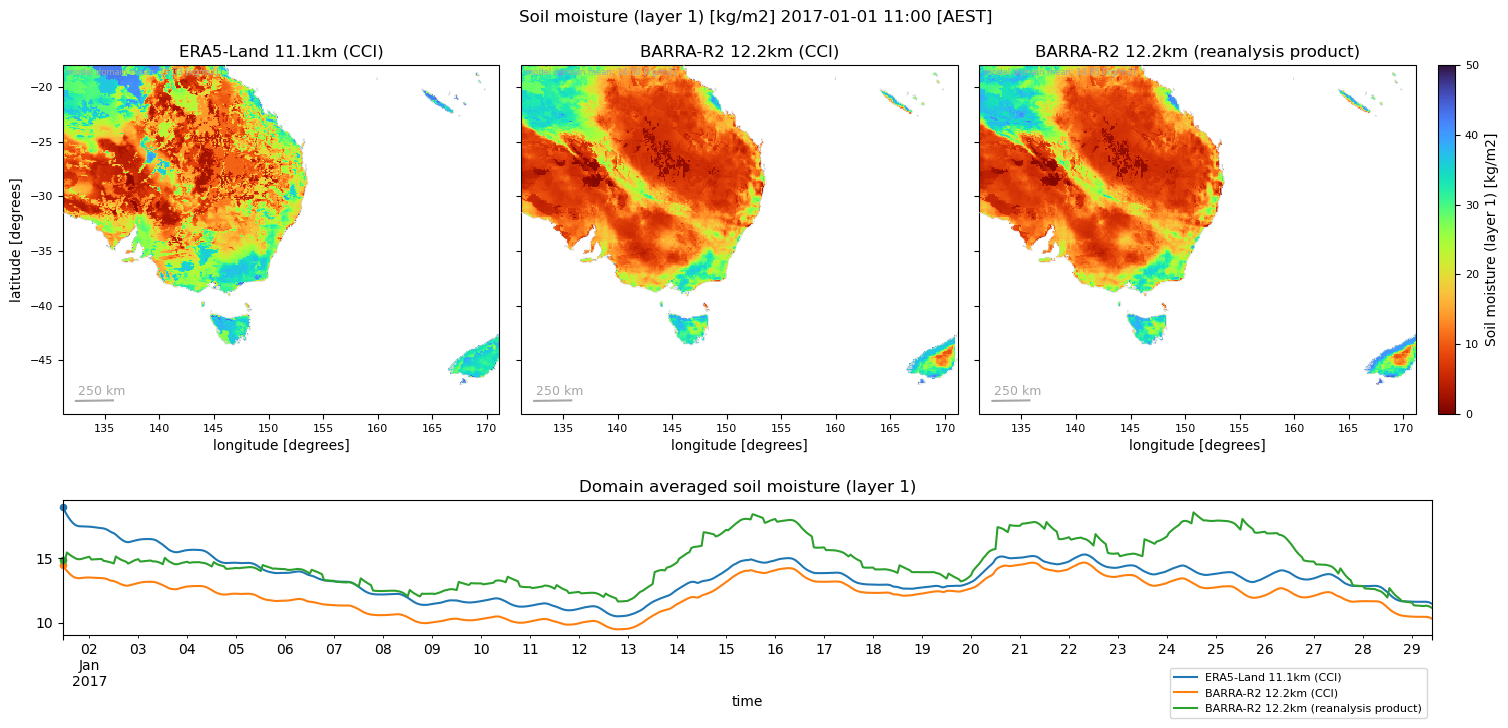

In [7]:
vopts = cf.update_opts(opts)

fig, fname = create_spatial_timeseries_plot(ds.sel(depth=0.05), exps, suffix='_12km', itime=0, distance=250)

**Figure 1**: Soil moisture (layer 1) after first timestep, and with timeseries below. To note:
 - ERA5-Land (blue) initialises wetter than both RNS:BARRA-R2 (orange) and the BARRA reanalysis product (green)
 - Domain-averaged wetness in top layer (5cm) persists through month-long simulation, but finishes closer than initialisd
 - BARRA reanalysis has unphysical jumps from DA pushing model towards observations at start of "cycle"
    

plotting soil_moisture_l1 2017-01-01T11:00:00.000000000
E5L_11p1_CCI
BR2_12p2_CCI
fname: soil_moisture_l1_spatial_2017-01-01_1100_AEST_diff.png


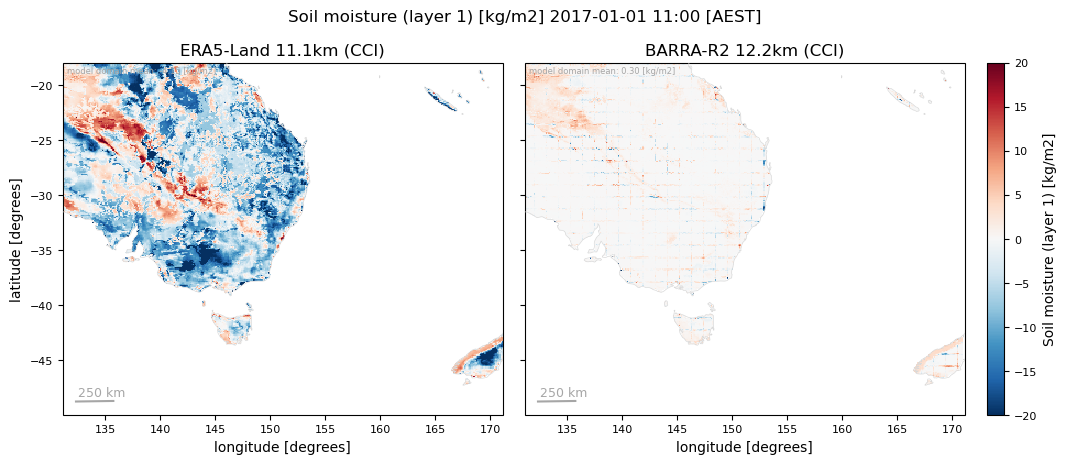

In [9]:
diff = ds['BARRA-R2'] - ds
vopts = cf.update_opts(opts,
            vmin=-20,
            vmax=20,
            cmap='RdBu_r',
        )

fig, fname = cf.plot_spatial(exps[0:2], diff.isel(time=0), vopts, [], stations, obs, slabels=True, fill_size=10,
    fill_obs=True, ncols=2, distance=250, suffix='_diff')

**Figure 2**: Difference in soil moisture (layer 1) with BARRA-R2 after first timestep. To note: 

 - **Striping is from interpolation for this analysis, not in original model data**
 - RNS-ERA5-Land mostly wetter, but with spatial variability, dryer in NW and some central locations
 - RNS-BARRA-R2 is initialised from BARRA-R2. 
 - RNS-BARRA-R2 is slightly wetter in far North-West, not sure where this is coming from

attempting to open 1 experiments:
['E5L_11p1_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/E5L_11p1_CCI_land_sea_mask.nc
  opening land_sea_mask E5L_11p1_CCI
dss includes time period
calculating mean between 2017-01-01 11:00 and 2017-01-29 10:00
plotting soil_moisture_l1 2017-01-01 11:00 - 2017-01-29 10:00
E5L_11p1_CCI
BR2_12p2_CCI
fname: soil_moisture_l1_spatial_2017-01-01_1100_to_2017-01-29_1000_AEST_12km_diff.png


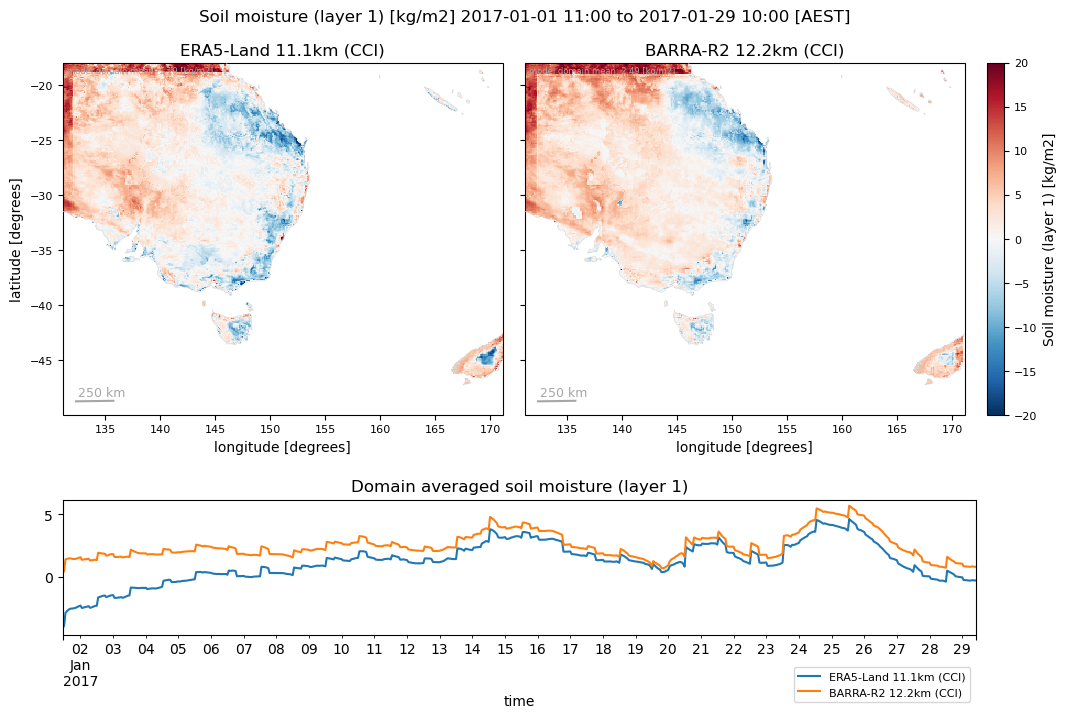

In [11]:
diff = ds['BARRA-R2'] - ds
vopts = cf.update_opts(opts,
            vmin=-20,
            vmax=20,
            cmap='RdBu_r',
        )

fig, fname = create_spatial_timeseries_plot(diff.sel(depth=0.05), exps=exps[0:2],
                                            suffix='_12km_diff', itime=None, distance=250)

**Figure 3**: Difference in soil moisture (layer 1) with BARRA-R2 over full simulation. To note:
 - Both end wetter in North East/ coastal, dryer in North West/ inland

## 1 km soil moisture

In [3]:
variable = 'soil_moisture_l1'
exps = [
        ### Parent models ###
        # 'E5L_11p1_CCI',
        # 'BR2_12p2_CCI',
        # ## ERA5-Land CCI ###
        # 'E5L_5_CCI',
        # 'E5L_1_CCI',
        'E5L_1_L_CCI',
        # ### ERA5-Land CCI WordCover ###
        # 'E5L_5_CCI_WC',
        # 'E5L_1_CCI_WC',
        # 'E5L_1_L_CCI_WC',
        # ### BARRA CCI ###
        # 'BR2_5_CCI',
        # 'BR2_1_CCI',
        'BR2_1_L_CCI',
        # ### BARRA CCI WorldCover ###
        # 'BR2_5_CCI_WC',
        # 'BR2_1_CCI_WC',
        # 'BR2_1_L_CCI_WC',
        # # ### BARRA IGBP ###
        # 'BR2_5_IGBP',
        # 'BR2_1_IGBP',
        # 'BR2_1_L_IGBP',
        # ### BARRA CCI no urban ###
        # 'BR2_5_CCI_no_urban',
        # 'BR2_1_CCI_no_urban',
        # 'BR2_1_L_CCI_no_urban',
        ### BARRA operational reanalysis ###
        # 'BARRA-R2',
        'BARRA-C2',
        ]

exp_colours, exp_plot_titles = set_up_plot_attrs(exps, plotpath)

# check if plotpath exists, make if necessary
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

print(f'processing {variable}')

opts = cf.get_variable_opts(variable)
ds = cf.open_output_netcdf(exps,opts,variable,datapath)

# convert to local time and update timezone
if local_time and ds.time.attrs['timezone'] == 'UTC': 
    print('updating from UTC to local time')
    ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
    ds.time.attrs.update({'timezone': 'AEST'})

ds = ds.compute()

ds

processing soil_moisture_l1
attempting to open 3 experiments:
['E5L_1_L_CCI', 'BR2_1_L_CCI', 'BARRA-C2']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/soil_moisture_l1/E5L_1_L_CCI_soil_moisture_l1.nc
  opening soil_moisture_l1 E5L_1_L_CCI
2: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/soil_moisture_l1/BR2_1_L_CCI_soil_moisture_l1.nc
  opening soil_moisture_l1 BR2_1_L_CCI
3: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/soil_moisture_l1/BARRA-C2_soil_moisture_l1.nc
loading BARRA-C2
updating from UTC to local time


<xarray.Dataset> Size: 7GB
Dimensions:      (depth: 1, latitude: 720, longitude: 960, time: 672)
Coordinates:
  * depth        (depth) float64 8B 0.05
  * latitude     (latitude) float32 3kB -37.14 -37.13 -37.12 ... -30.67 -30.67
  * longitude    (longitude) float32 4kB 146.9 146.9 146.9 ... 155.5 155.5 155.5
    crs          int32 4B 0
  * time         (time) datetime64[ns] 5kB 2017-01-01T11:00:00 ... 2017-01-29...
Data variables:
    E5L_1_L_CCI  (time, latitude, longitude) float32 2GB 36.75 36.75 ... nan nan
    BR2_1_L_CCI  (time, latitude, longitude) float32 2GB 34.91 34.88 ... nan nan
    BARRA-C2     (depth, time, latitude, longitude) float64 4GB 33.76 ... nan

attempting to open 1 experiments:
['E5L_1_L_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/E5L_1_L_CCI_land_sea_mask.nc
  opening land_sea_mask E5L_1_L_CCI
dss includes time period
calculating mean between 2017-01-01 11:00 and 2017-01-29 10:00
plotting soil_moisture_l1 2017-01-01 11:00 - 2017-01-29 10:00
E5L_1_L_CCI
BR2_1_L_CCI
fname: soil_moisture_l1_spatial_2017-01-01_1100_to_2017-01-29_1000_AEST_1km_diff.png


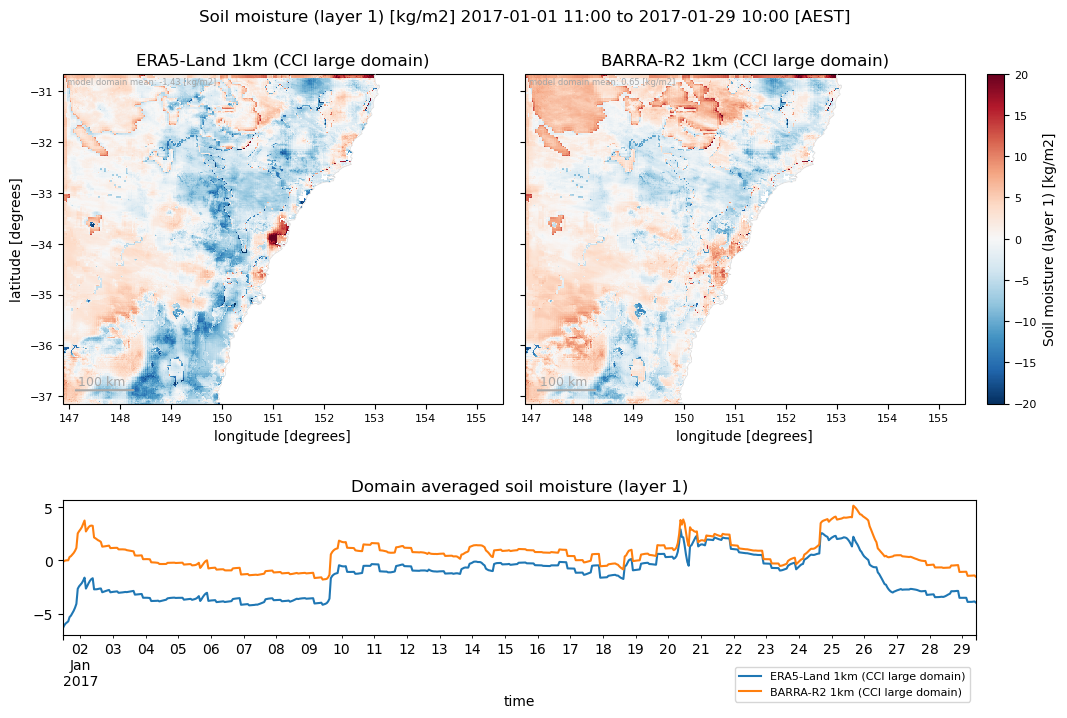

In [8]:

diff = ds['BARRA-C2'] - ds
vopts = cf.update_opts(opts,
            vmin=-20,
            vmax=20,
            cmap='RdBu_r',
        )

fig, fname = create_spatial_timeseries_plot(diff.sel(depth=0.05), exps=exps[0:2],
                                            suffix='_1km_diff', itime=None, distance=100)

**Figure 4**: Difference in soil moisture (layer 1) with BARRA-R2 over full simulation in 1km domain. To note:

 -  ERA5-Land remains wet throught much of the domain, except for around Sydney, which remains dry.
 -  ERA5-Land is dry around Sydney, likely because of different DA approaches to urban areas (the UM is wet-biased in and aroudn cities because of spurious signals picked up by artificial surfaces)
 -  BARRA-R2 does a better job overal, with less variability from zero.

### Temperature analysis

In [34]:
variable = 'air_temperature'
exps = [
        ### Parent models ###
        # 'E5L_11p1_CCI',
        # 'BR2_12p2_CCI',
        # ## ERA5-Land CCI ###
        # 'E5L_5_CCI',
        'E5L_1_CCI',
        # 'E5L_1_L_CCI',
        # ### ERA5-Land CCI WordCover ###
        # 'E5L_5_CCI_WC',
        # 'E5L_1_CCI_WC',
        # 'E5L_1_L_CCI_WC',
        # ### BARRA CCI ###
        # 'BR2_5_CCI',
        'BR2_1_CCI',
        # 'BR2_1_L_CCI',
        # ### BARRA CCI WorldCover ###
        # 'BR2_5_CCI_WC',
        # 'BR2_1_CCI_WC',
        # 'BR2_1_L_CCI_WC',
        # # ### BARRA IGBP ###
        # 'BR2_5_IGBP',
        # 'BR2_1_IGBP',
        # 'BR2_1_L_IGBP',
        # ### BARRA CCI no urban ###
        # 'BR2_5_CCI_no_urban',
        # 'BR2_1_CCI_no_urban',
        # 'BR2_1_L_CCI_no_urban',
        ### BARRA operational reanalysis ###
        # 'BARRA-R2',
        'BARRA-C2',
        ]

exp_colours, exp_plot_titles = set_up_plot_attrs(exps, plotpath)

# check if plotpath exists, make if necessary
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

print(f'processing {variable}')

opts = cf.get_variable_opts(variable)
ds = cf.open_output_netcdf(exps,opts,variable,datapath)

# convert to local time and update timezone
if local_time and ds.time.attrs['timezone'] == 'UTC': 
    print('updating from UTC to local time')
    ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
    ds.time.attrs.update({'timezone': 'AEST'})

ds = ds.compute()
ds

processing air_temperature
attempting to open 3 experiments:
['E5L_1_CCI', 'BR2_1_CCI', 'BARRA-C2']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/E5L_1_CCI_air_temperature_1p5m.nc
  opening air_temperature E5L_1_CCI
2: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BR2_1_CCI_air_temperature_1p5m.nc
  opening air_temperature BR2_1_CCI
3: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BARRA-C2_air_temperature_1p5m.nc
loading BARRA-C2
updating from UTC to local time


<xarray.Dataset> Size: 2GB
Dimensions:    (latitude: 360, longitude: 450, time: 672)
Coordinates:
  * latitude   (latitude) float32 1kB -35.52 -35.51 -35.5 ... -32.29 -32.28
  * longitude  (longitude) float32 2kB 149.2 149.2 149.2 ... 153.2 153.2 153.2
    height     float64 8B 1.5
    crs        int32 4B 0
  * time       (time) datetime64[ns] 5kB 2017-01-01T11:00:00 ... 2017-01-29T1...
Data variables:
    E5L_1_CCI  (time, latitude, longitude) float32 435MB 24.71 24.66 ... 26.51
    BR2_1_CCI  (time, latitude, longitude) float32 435MB 24.87 24.73 ... 26.43
    BARRA-C2   (time, latitude, longitude) float64 871MB 22.57 22.57 ... 26.04

### get observations

In [37]:
variable = 'air_temperature'
if variable in ['sensible_heat_flux','latent_heat_flux','soil_moisture_l1','soil_moisture_l2','soil_moisture_l3']:
    # print('getting flux obs')
    obs, stations = cf.get_flux_obs(variable, local_time_offset=None)
    print('no obs available')
elif variable in ['air_temperature','dew_point_temperature']:
    obs, stations = cf.process_station_netcdf(variable, stationpath, local_time_offset=local_time_offset)
else:
    print('no obs available')
    # set up dummy obs and stations dataframes
    obs, stations = pd.DataFrame(), pd.DataFrame()
    sids, sufix = [], ''

# convert to local time if obs is not None
if local_time and not obs.empty:
    obs.index = obs.index + pd.Timedelta(f'{local_time_offset}h')

# trim obs dataframe to ds time period
obs = obs.loc[ds.time.min().values:ds.time.max().values]

# select only obs that align with ds model times
if not obs.empty:
    obs = obs.loc[ds.time.values]

# select all stations
sids, suffix = stations.index.tolist(), '_all'

# trim sids to those in ds
sids, suffix = cf.trim_sids(ds, obs, sids, stations), '_trimmed'
obs

opening /g/data/ce10/users/mjl561/observations/AWS/au-2000_2024_5min/all_stations_air_temperature_from_2013-01-01.nc


31222  94255      58208      52088      87031  \
time                                                                     
2017-01-01 11:00:00  31.600000   16.0  37.599998  39.099998  18.799999   
2017-01-01 12:00:00  32.099998   15.8  38.400002  39.799999  18.700001   
2017-01-01 13:00:00  31.900000   16.5  39.799999  40.299999  20.000000   
2017-01-01 14:00:00  30.700001   16.9  39.099998  40.400002  17.799999   
2017-01-01 15:00:00  31.400000   17.0  30.799999  31.500000  17.799999   
...                        ...    ...        ...        ...        ...   
2017-01-29 06:00:00  26.000000   11.6  20.700001  25.400000  17.100000   
2017-01-29 07:00:00  26.600000   13.8  22.400000  28.100000  18.100000   
2017-01-29 08:00:00  28.799999   15.8  25.299999  30.299999  19.000000   
2017-01-29 09:00:00  30.000000   16.4  28.400000  32.900002  19.700001   
2017-01-29 10:00:00  30.500000   17.5  29.600000  34.099998  20.900000   

                         86068      72161      41522      34035      30124  \
time                                                                         
2017-01-01 11:00:00  21.700001  17.400000  33.400002  30.600000  30.100000   
2017-01-01 12:00:00  19.900000  17.000000  34.700001  33.099998  31.400000   
2017-01-01 13:00:00  19.900000  16.900000  35.900002  33.099998  32.599998   
2017-01-01 14:00:00  20.799999  16.900000  37.900002  33.500000  34.099998   
2017-01-01 15:00:00  18.500000  16.700001  38.400002  34.299999  34.099998   
...                        ...        ...        ...        ...        ...   
2017-01-29 06:00:00        NaN  17.799999  20.500000  22.000000  24.799999   
2017-01-29 07:00:00  15.800000  18.900000  23.299999  24.600000  26.100000   
2017-01-29 08:00:00  18.100000  19.400000  24.700001  27.000000  28.299999   
2017-01-29 09:00:00        NaN  20.100000  26.400000  28.200001  29.700001   
2017-01-29 10:00:00        NaN  20.799999  28.799999  30.299999  31.600000   

                     ...      33294      80128  61430  41097      74148  \
time                 ...                                                  
2017-01-01 11:00:00  ...  29.000000  21.000000    NaN    NaN  28.600000   
2017-01-01 12:00:00  ...  29.200001  20.900000    NaN    NaN  29.400000   
2017-01-01 13:00:00  ...  29.299999  22.000000    NaN    NaN  29.900000   
2017-01-01 14:00:00  ...  29.400000  23.799999    NaN    NaN  30.600000   
2017-01-01 15:00:00  ...  29.100000  25.100000    NaN    NaN  32.099998   
...                  ...        ...        ...    ...    ...        ...   
2017-01-29 06:00:00  ...  26.900000  14.800000    NaN    NaN  17.400000   
2017-01-29 07:00:00  ...  27.200001  18.200001    NaN    NaN  22.799999   
2017-01-29 08:00:00  ...  27.500000  22.700001    NaN    NaN  28.900000   
2017-01-29 09:00:00  ...  28.000000  26.299999    NaN    NaN  32.000000   
2017-01-29 10:00:00  ...  29.100000  29.400000    NaN    NaN  35.000000   

                         76031      40043      99005      33045      74037  
time                                                                        
2017-01-01 11:00:00  23.700001  29.000000  18.600000  30.000000  27.900000  
2017-01-01 12:00:00  24.100000  29.400000  18.400000  30.400000  29.000000  
2017-01-01 13:00:00  26.400000  29.299999  19.200001  30.500000  30.299999  
2017-01-01 14:00:00  26.600000  28.700001  17.900000  30.299999  29.799999  
2017-01-01 15:00:00  27.700001  27.900000  18.700001  29.900000  31.500000  
...                        ...        ...        ...        ...        ...  
2017-01-29 06:00:00  19.299999  25.900000  12.900000  25.100000  21.500000  
2017-01-29 07:00:00  20.900000  27.700001  16.600000  26.700001  25.200001  
2017-01-29 08:00:00  23.700001  28.600000  20.200001  27.500000  29.000000  
2017-01-29 09:00:00  26.900000  28.400000  20.000000  30.100000  31.900000  
2017-01-29 10:00:00  30.100000  29.299999  19.299999  28.500000  35.400002  

[672 rows x 366 columns]

attempting to open 1 experiments:
['E5L_1_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/E5L_1_CCI_land_sea_mask.nc
  opening land_sea_mask E5L_1_CCI
dss includes time period
calculating mean between 2017-01-01 11:00 and 2017-01-29 10:00
plotting air_temperature 2017-01-01 11:00 - 2017-01-29 10:00
E5L_1_CCI
BR2_1_CCI
BARRA-C2
fname: air_temperature_1p5m_spatial_2017-01-01_1100_to_2017-01-29_1000_AEST_1km.png


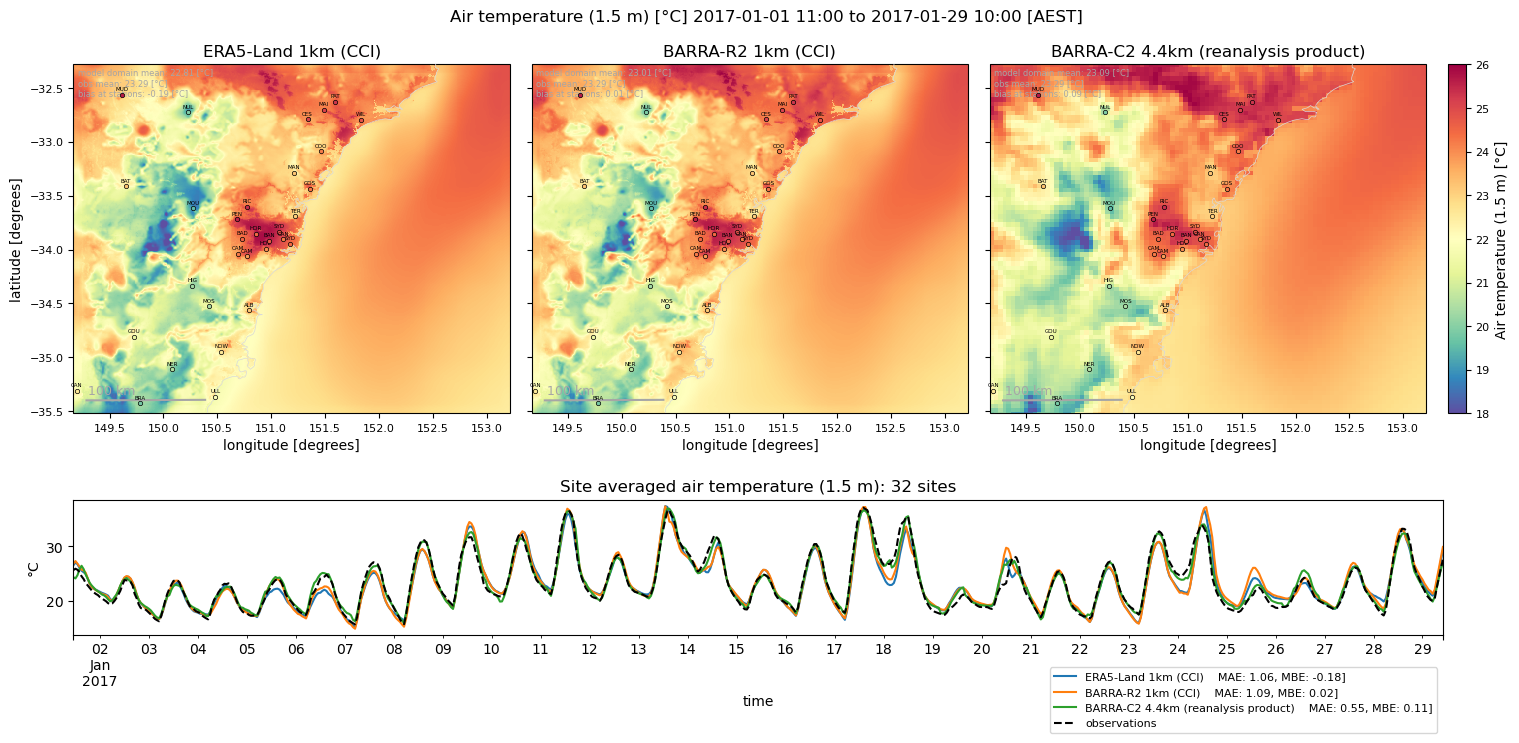

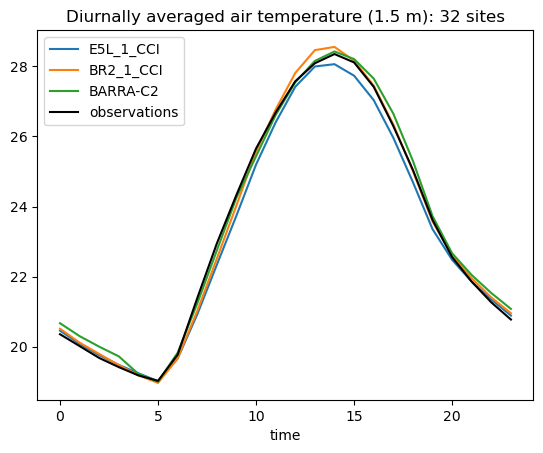

In [38]:
vopts = cf.update_opts(opts,
            vmin=18,
            vmax=26,
            cmap='Spectral_r',
        )

fig, fname = create_spatial_timeseries_plot_vs_obs(ds, exps, suffix='_1km', itime=None)

gathering RICHMOND RAAF data
gathering CESSNOCK AIRPORT AWS data
gathering HORSLEY PARK EQUESTRIAN CENTRE AWS data
gathering MOUNT BOYCE AWS data
gathering HIGH RANGE AWS (WANGANDERRY) data
gathering SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE) data
gathering CANTERBURY RACECOURSE AWS data
gathering CAMDEN AIRPORT AWS data
gathering MAITLAND AIRPORT AWS data
gathering MUDGEE AIRPORT AWS data
gathering NEWCASTLE NOBBYS SIGNAL STATION AWS data
gathering COORANBONG (LAKE MACQUARIE AWS) data
gathering GOSFORD AWS data
gathering KIAMA (BOMBO HEADLAND) data
gathering TERREY HILLS AWS data
gathering WILLIAMTOWN RAAF data
gathering PENRITH LAKES AWS data
gathering BELLAMBI AWS data
gathering BRAIDWOOD RACECOURSE AWS data
gathering CAMPBELLTOWN (MOUNT ANNAN) data
gathering MOSS VALE AWS data
gathering NULLO MOUNTAIN AWS data
gathering NORAH HEAD AWS data
gathering BADGERYS CREEK AWS data
gathering NERRIGA AWS data
gathering MANGROVE MOUNTAIN AWS data
gathering ULLADULLA AWS data
gathering BATHURST 

/home/561/mjl561/git/RNS_Sydney_1km/plotting_code/common_functions.py:775: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = all_stats.mean(axis=1).unstack().applymap(lambda x: opts['fmt'].format(x)).rename(columns={


mean stats
          MAE [°C] MBE [°C]  RMSE     R <±2 °C [%]
E5L_1_CCI     1.69    -0.22  2.31  0.87      69.92
BR2_1_CCI     1.70    -0.04  2.34  0.87      69.40
BARRA-C2      1.22     0.26  1.67  0.94      82.17


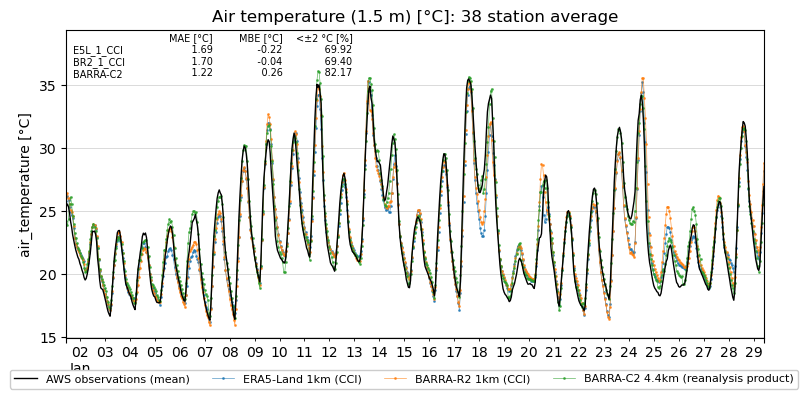

In [39]:
fig,fname, _ = cf.plot_station_data_avg_timeseries(ds, obs, sids, exps, stations, opts, suffix)

In [40]:
variable = 'air_temperature'
exps = [
        ### Parent models ###
        # 'E5L_11p1_CCI',
        # 'BR2_12p2_CCI',
        # ## ERA5-Land CCI ###
        'E5L_5_CCI',
        # 'E5L_1_CCI',
        # 'E5L_1_L_CCI',
        # ### ERA5-Land CCI WordCover ###
        'E5L_5_CCI_WC',
        # 'E5L_1_CCI_WC',
        # 'E5L_1_L_CCI_WC',
        # ### BARRA CCI ###
        # 'BR2_5_CCI',
        # 'BR2_1_CCI',
        # 'BR2_1_L_CCI',
        # ### BARRA CCI WorldCover ###
        # 'BR2_5_CCI_WC',
        # 'BR2_1_CCI_WC',
        # 'BR2_1_L_CCI_WC',
        # # ### BARRA IGBP ###
        # 'BR2_5_IGBP',
        # 'BR2_1_IGBP',
        # 'BR2_1_L_IGBP',
        # ### BARRA CCI no urban ###
        # 'BR2_5_CCI_no_urban',
        # 'BR2_1_CCI_no_urban',
        # 'BR2_1_L_CCI_no_urban',
        ### BARRA operational reanalysis ###
        # 'BARRA-R2',
        'BARRA-C2',
        ]

exp_colours, exp_plot_titles = set_up_plot_attrs(exps, plotpath)

# check if plotpath exists, make if necessary
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

print(f'processing {variable}')

opts = cf.get_variable_opts(variable)
ds = cf.open_output_netcdf(exps,opts,variable,datapath)

# convert to local time and update timezone
if local_time and ds.time.attrs['timezone'] == 'UTC': 
    print('updating from UTC to local time')
    ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
    ds.time.attrs.update({'timezone': 'AEST'})

ds = ds.compute()
ds

processing air_temperature
attempting to open 3 experiments:
['E5L_5_CCI', 'E5L_5_CCI_WC', 'BARRA-C2']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/E5L_5_CCI_air_temperature_1p5m.nc
  opening air_temperature E5L_5_CCI
2: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/E5L_5_CCI_WC_air_temperature_1p5m.nc
  opening air_temperature E5L_5_CCI_WC
3: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BARRA-C2_air_temperature_1p5m.nc
loading BARRA-C2
updating from UTC to local time


<xarray.Dataset> Size: 1GB
Dimensions:       (latitude: 320, longitude: 400, time: 672)
Coordinates:
  * latitude      (latitude) float32 1kB -41.1 -41.05 -41.01 ... -26.79 -26.74
  * longitude     (longitude) float32 2kB 142.2 142.2 142.3 ... 160.1 160.1
    height        float64 8B 1.5
    crs           int32 4B 0
  * time          (time) datetime64[ns] 5kB 2017-01-01T11:00:00 ... 2017-01-2...
Data variables:
    E5L_5_CCI     (time, latitude, longitude) float32 344MB 13.98 ... 24.68
    E5L_5_CCI_WC  (time, latitude, longitude) float32 344MB 13.98 ... 24.76
    BARRA-C2      (time, latitude, longitude) float64 688MB 13.6 13.62 ... nan

attempting to open 1 experiments:
['E5L_5_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/E5L_5_CCI_land_sea_mask.nc
  opening land_sea_mask E5L_5_CCI
dss includes time period
calculating mean between 2017-01-01 11:00 and 2017-01-29 10:00
plotting air_temperature 2017-01-01 11:00 - 2017-01-29 10:00
E5L_5_CCI
E5L_5_CCI_WC
BARRA-C2
fname: air_temperature_1p5m_spatial_2017-01-01_1100_to_2017-01-29_1000_AEST_5km.png


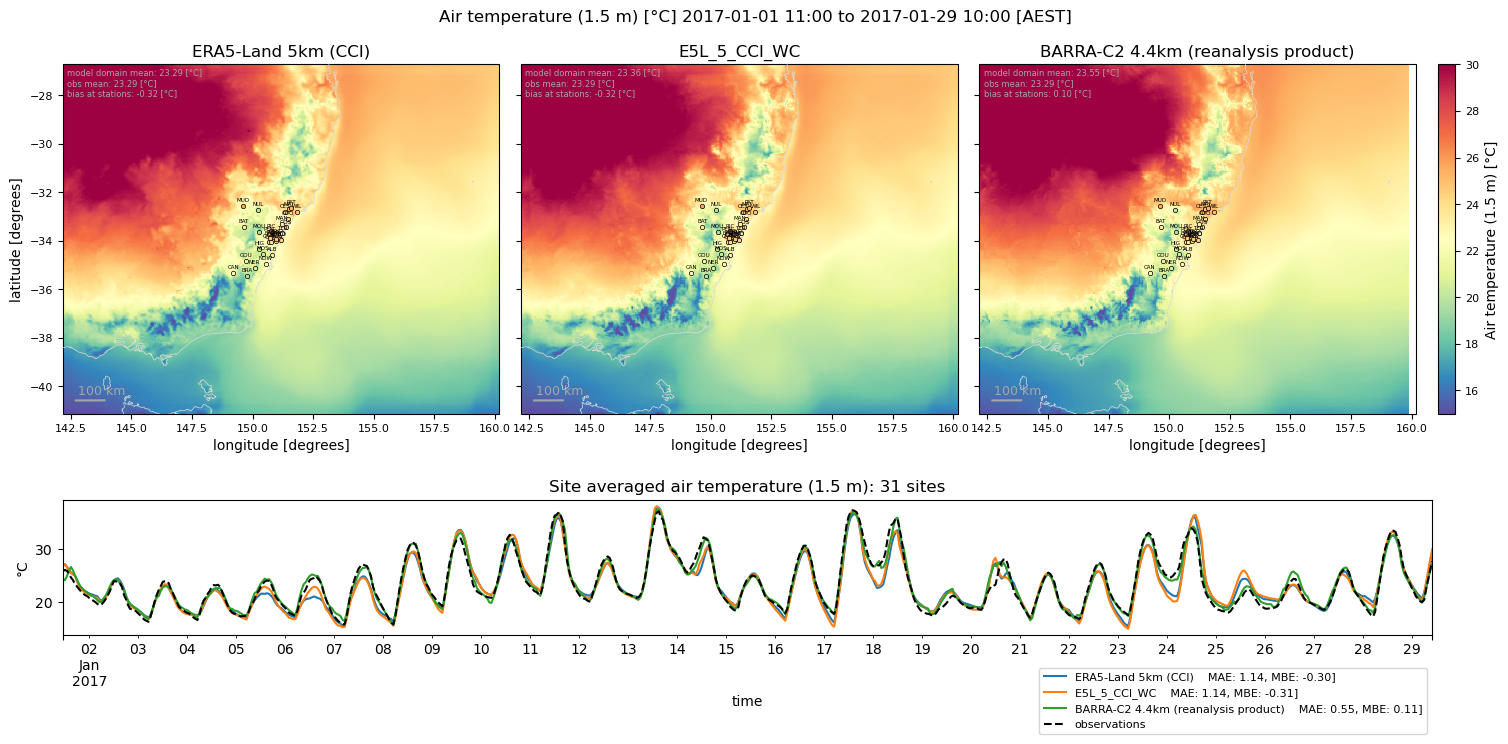

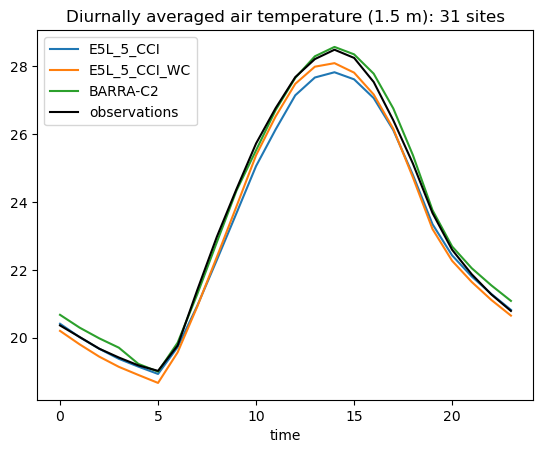

In [41]:
vopts = cf.update_opts(opts,
            vmin=15,
            vmax=30,
            cmap='Spectral_r',
        )

fig, fname = create_spatial_timeseries_plot_vs_obs(ds, exps, suffix='_5km', itime=None)

In [42]:
variable = 'air_temperature'
if variable in ['sensible_heat_flux','latent_heat_flux','soil_moisture_l1','soil_moisture_l2','soil_moisture_l3']:
    # print('getting flux obs')
    obs, stations = cf.get_flux_obs(variable, local_time_offset=None)
    print('no obs available')
elif variable in ['air_temperature','dew_point_temperature']:
    obs, stations = cf.process_station_netcdf(variable, stationpath, local_time_offset=local_time_offset)
else:
    print('no obs available')
    # set up dummy obs and stations dataframes
    obs, stations = pd.DataFrame(), pd.DataFrame()
    sids, sufix = [], ''

# convert to local time if obs is not None
if local_time and not obs.empty:
    obs.index = obs.index + pd.Timedelta(f'{local_time_offset}h')

# trim obs dataframe to ds time period
obs = obs.loc[ds.time.min().values:ds.time.max().values]

# select only obs that align with ds model times
if not obs.empty:
    obs = obs.loc[ds.time.values]

# select all stations
sids, suffix = stations.index.tolist(), '_all'

# trim sids to those in ds
sids, suffix = cf.trim_sids(ds, obs, sids, stations), '_trimmed'
obs

opening /g/data/ce10/users/mjl561/observations/AWS/au-2000_2024_5min/all_stations_air_temperature_from_2013-01-01.nc


31222  94255      58208      52088      87031  \
time                                                                     
2017-01-01 11:00:00  31.600000   16.0  37.599998  39.099998  18.799999   
2017-01-01 12:00:00  32.099998   15.8  38.400002  39.799999  18.700001   
2017-01-01 13:00:00  31.900000   16.5  39.799999  40.299999  20.000000   
2017-01-01 14:00:00  30.700001   16.9  39.099998  40.400002  17.799999   
2017-01-01 15:00:00  31.400000   17.0  30.799999  31.500000  17.799999   
...                        ...    ...        ...        ...        ...   
2017-01-29 06:00:00  26.000000   11.6  20.700001  25.400000  17.100000   
2017-01-29 07:00:00  26.600000   13.8  22.400000  28.100000  18.100000   
2017-01-29 08:00:00  28.799999   15.8  25.299999  30.299999  19.000000   
2017-01-29 09:00:00  30.000000   16.4  28.400000  32.900002  19.700001   
2017-01-29 10:00:00  30.500000   17.5  29.600000  34.099998  20.900000   

                         86068      72161      41522      34035      30124  \
time                                                                         
2017-01-01 11:00:00  21.700001  17.400000  33.400002  30.600000  30.100000   
2017-01-01 12:00:00  19.900000  17.000000  34.700001  33.099998  31.400000   
2017-01-01 13:00:00  19.900000  16.900000  35.900002  33.099998  32.599998   
2017-01-01 14:00:00  20.799999  16.900000  37.900002  33.500000  34.099998   
2017-01-01 15:00:00  18.500000  16.700001  38.400002  34.299999  34.099998   
...                        ...        ...        ...        ...        ...   
2017-01-29 06:00:00        NaN  17.799999  20.500000  22.000000  24.799999   
2017-01-29 07:00:00  15.800000  18.900000  23.299999  24.600000  26.100000   
2017-01-29 08:00:00  18.100000  19.400000  24.700001  27.000000  28.299999   
2017-01-29 09:00:00        NaN  20.100000  26.400000  28.200001  29.700001   
2017-01-29 10:00:00        NaN  20.799999  28.799999  30.299999  31.600000   

                     ...      33294      80128  61430  41097      74148  \
time                 ...                                                  
2017-01-01 11:00:00  ...  29.000000  21.000000    NaN    NaN  28.600000   
2017-01-01 12:00:00  ...  29.200001  20.900000    NaN    NaN  29.400000   
2017-01-01 13:00:00  ...  29.299999  22.000000    NaN    NaN  29.900000   
2017-01-01 14:00:00  ...  29.400000  23.799999    NaN    NaN  30.600000   
2017-01-01 15:00:00  ...  29.100000  25.100000    NaN    NaN  32.099998   
...                  ...        ...        ...    ...    ...        ...   
2017-01-29 06:00:00  ...  26.900000  14.800000    NaN    NaN  17.400000   
2017-01-29 07:00:00  ...  27.200001  18.200001    NaN    NaN  22.799999   
2017-01-29 08:00:00  ...  27.500000  22.700001    NaN    NaN  28.900000   
2017-01-29 09:00:00  ...  28.000000  26.299999    NaN    NaN  32.000000   
2017-01-29 10:00:00  ...  29.100000  29.400000    NaN    NaN  35.000000   

                         76031      40043      99005      33045      74037  
time                                                                        
2017-01-01 11:00:00  23.700001  29.000000  18.600000  30.000000  27.900000  
2017-01-01 12:00:00  24.100000  29.400000  18.400000  30.400000  29.000000  
2017-01-01 13:00:00  26.400000  29.299999  19.200001  30.500000  30.299999  
2017-01-01 14:00:00  26.600000  28.700001  17.900000  30.299999  29.799999  
2017-01-01 15:00:00  27.700001  27.900000  18.700001  29.900000  31.500000  
...                        ...        ...        ...        ...        ...  
2017-01-29 06:00:00  19.299999  25.900000  12.900000  25.100000  21.500000  
2017-01-29 07:00:00  20.900000  27.700001  16.600000  26.700001  25.200001  
2017-01-29 08:00:00  23.700001  28.600000  20.200001  27.500000  29.000000  
2017-01-29 09:00:00  26.900000  28.400000  20.000000  30.100000  31.900000  
2017-01-29 10:00:00  30.100000  29.299999  19.299999  28.500000  35.400002  

[672 rows x 366 columns]

attempting to open 1 experiments:
['E5L_5_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/E5L_5_CCI_land_sea_mask.nc
  opening land_sea_mask E5L_5_CCI
dss includes time period
calculating mean between 2017-01-01 11:00 and 2017-01-29 10:00
plotting air_temperature 2017-01-01 11:00 - 2017-01-29 10:00
E5L_5_CCI
E5L_5_CCI_WC
BARRA-C2
fname: air_temperature_1p5m_spatial_2017-01-01_1100_to_2017-01-29_1000_AEST_5km.png


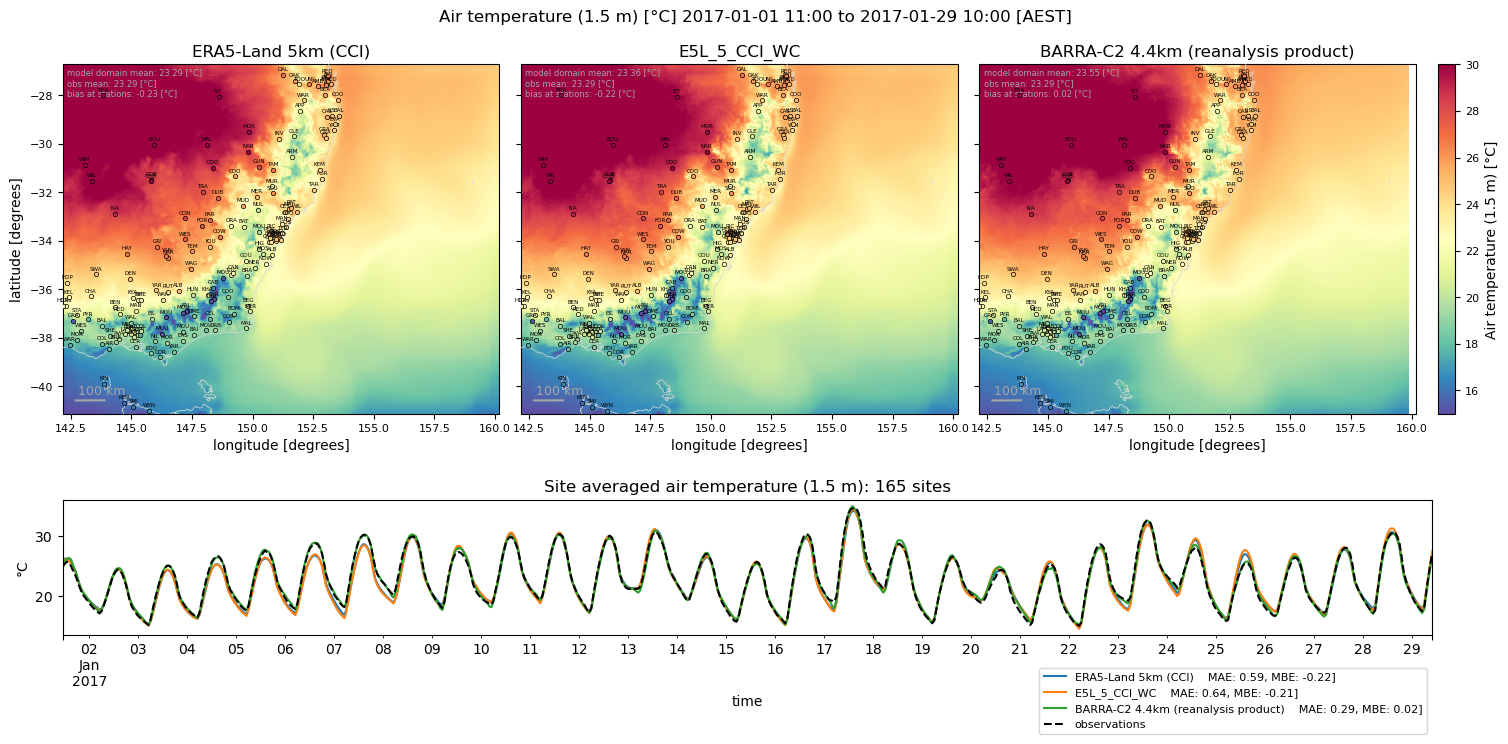

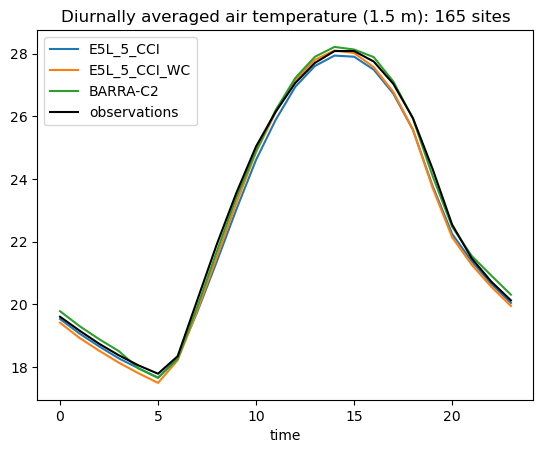

In [43]:
vopts = cf.update_opts(opts,
            vmin=15,
            vmax=30,
            cmap='Spectral_r',
        )

fig, fname = create_spatial_timeseries_plot_vs_obs(ds, exps, suffix='_5km', itime=None)

gathering CASINO AIRPORT AWS data
gathering WALGETT AIRPORT AWS data
gathering LAVERTON RAAF data
gathering VIEWBANK data
gathering CABRAMURRA SMHEA AWS data
gathering DALBY AIRPORT data
gathering AVALON AIRPORT data
gathering SCORESBY RESEARCH INSTITUTE data
gathering BENDIGO AIRPORT data
gathering RICHMOND RAAF data
gathering CESSNOCK AIRPORT AWS data
gathering SWAN HILL AERODROME data
gathering COONAMBLE AIRPORT AWS data
gathering CAPE OTWAY LIGHTHOUSE data
gathering KYABRAM data
gathering COLAC (MOUNT GELLIBRAND) data
gathering PORT FAIRY AWS data
gathering KENNAOOK/CAPE GRIM data
gathering BYRON BAY (CAPE BYRON AWS) data
gathering WILSONS PROMONTORY LIGHTHOUSE data
gathering HORSLEY PARK EQUESTRIAN CENTRE AWS data
gathering REDESDALE data
gathering NARRABRI AIRPORT AWS data
gathering PERISHER VALLEY AWS data
gathering KING ISLAND AIRPORT data
gathering BRISBANE data
gathering MOUNT BOYCE AWS data
gathering CONDOBOLIN AIRPORT AWS data
gathering TRANGIE RESEARCH STATION AWS data
gat

/home/561/mjl561/git/RNS_Sydney_1km/plotting_code/common_functions.py:775: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = all_stats.mean(axis=1).unstack().applymap(lambda x: opts['fmt'].format(x)).rename(columns={


mean stats
             MAE [°C] MBE [°C]  RMSE     R <±2 °C [%]
E5L_5_CCI        1.76    -0.25  2.29  0.88      66.57
E5L_5_CCI_WC     1.66    -0.25  2.20  0.88      69.37
BARRA-C2         1.27     0.07  1.70  0.92      80.27


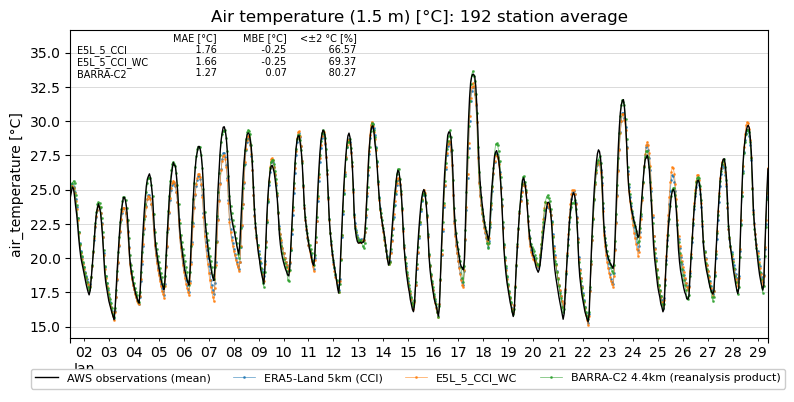

In [44]:
fig,fname, _ = cf.plot_station_data_avg_timeseries(ds, obs, sids, exps, stations, opts, suffix)